<h1>Transformer</h1>

# import

In [4]:
import requests
import zipfile
import os

# 스페인어-영어 말 묶음 데이터

In [1]:
import os
os.environ["HTTP_PROXY"] = "70.10.15.10:8080"
os.environ['HTTPS_PROXY'] = "70.10.15.10:8080"
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['PYTHONHTTPSVERIFY'] ='0' 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context



In [2]:
# 스페인어-영어 말 묶음 다운로드
url ='http://www.manythings.org/anki/spa-eng.zip'
filename = 'spa_eng.zip'

In [5]:
# 강사가 별도로 파일을 제공했다면 이 셀은 실행하지 마세요.
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
}

with open(filename, 'wb') as f:
    r = requests.get(url, headers=headers)
    f.write(r.content)

In [6]:
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())


In [7]:
# 영-스 병렬 말묶음 읽기
# 0, 1번 열만 사용 (2번 열은 라이선스 정보)
import pandas as pd

df = pd.read_csv('spa.txt', names=['eng', 'spa'], sep='\t', usecols=[0,1])
df

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
140863,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
140864,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
140865,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."
140866,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...


In [ ]:
n_samples = 50000 # 5만개 데이터를 학습
train = df[:n_samples].copy()
train.head()

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


## 텍스트 전처리
* 액센트 기호 제거
  * `unicodedata.normalize(form, unistr)` : unistr에 대한 정규화 형식
    * 동일한 문제에 대해 다른 코드값 존재, 정규화 필요
      * 예) 옴(Ω)와 오메가(Ω), 합자(é)
    * form={'NFC', 'NFD', 'NFKC', 'NFKD'}
  * `unicodedata.category(chr)` : 문자에 할당된 일반 범주
    * 'Mn' : Mark nonspacing, 액센트 기호
    * https://en.wikipedia.org/wiki/Template:General_Category_(Unicode)

In [ ]:
import unicodedata
print(train['spa'][100])
{c:unicodedata.category(c) for c in unicodedata.normalize('NFD', train['spa'][100])}

Sé.


{'S': 'Lu', 'e': 'Ll', '́': 'Mn', '.': 'Po'}

In [ ]:
import unicodedata

# 액센트 기호 제거 함수
def removeAccents(x):
    char_list = []
    for char in unicodedata.normalize('NFD', x):
        if unicodedata.category(char) != 'Mn': # accent 기호
            char_list.append(char)
    return ''.join(char_list)

print('제거 전:', train.loc[1109, 'spa'])
print('제거 후:', removeAccents(train.loc[1109, 'spa']))

제거 전: Inténtalo de nuevo.
제거 후: Intentalo de nuevo.


In [ ]:
import re

# 전처리 함수 정의
def text_preprocess(text):
    # 액센트 기호 제거
    text = removeAccents(text.lower())

    # 알파벳 및 일부 기호(물음표, 느낌표, 마침표)를 제외한 문자 제거
    text = re.sub(r'[^a-z0-9!.?]+', r' ', text)

    # 기호와 단어 사이 공백 추가
    text = re.sub(r'([?.!])', r' \1', text)

    # 연속 공백 제거
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [ ]:
# 전처리 함수 동작 확인
print('영어 문장 원본: \t', train.loc[219, 'eng'].strip())
print('영어 문장 전처리: \t' ,text_preprocess(train.loc[219, 'eng']))
print('스페인어 문장 원본: \t', train.loc[219, 'spa'])
print('스페인어 문장 전처리: \t', text_preprocess(train.loc[219, 'spa']))

영어 문장 원본: 	 Hold it.
영어 문장 전처리: 	 hold it .
스페인어 문장 원본: 	 Sosténgala.
스페인어 문장 전처리: 	 sostengala .


In [ ]:
# 스페인어 인코더 입력 전처리
words = train['spa'].apply(text_preprocess).str.split()
spa_encoder_input_sentences = [word for word in words]

In [ ]:
# 영어 디코더 입력/레이블 전처리
eng_preprocessed_series = train['eng'].apply(text_preprocess)
input_words = ('<sos> ' + eng_preprocessed_series).str.split()
label_words = (eng_preprocessed_series + ' <eos>').str.split()

eng_decoder_input_sentences = [word for word in input_words]
eng_decoder_label_sentences = [word for word in label_words]

In [ ]:
# 전처리된 문장 확인
print('Encoder Inputs: ', spa_encoder_input_sentences[:3])
print('Decoder Inputs: ', eng_decoder_input_sentences[:3])
print('Decoder Labels: ', eng_decoder_label_sentences[:3])

Encoder Inputs:  [['ve', '.'], ['vete', '.'], ['vaya', '.']]
Decoder Inputs:  [['<sos>', 'go', '.'], ['<sos>', 'go', '.'], ['<sos>', 'go', '.']]
Decoder Labels:  [['go', '.', '<eos>'], ['go', '.', '<eos>'], ['go', '.', '<eos>']]


## 토큰화

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import numpy as np


def token_generator(data):
    for x in data:
        yield x

In [ ]:
# 스페인어 토큰화
vocab_spa_torch = build_vocab_from_iterator(
    iterator=token_generator(spa_encoder_input_sentences),
    specials=['<PAD>', '<OOV>'])
vocab_spa_torch.set_default_index(vocab_spa_torch['<OOV>'])
len(vocab_spa_torch.get_stoi())

12933

In [ ]:
# 영어 토큰화
vocab_eng_torch = build_vocab_from_iterator(
    iterator=token_generator(eng_decoder_input_sentences+eng_decoder_label_sentences),
    specials=['<PAD>', '<OOV>'])
vocab_eng_torch.set_default_index(vocab_eng_torch['<OOV>'])
len(vocab_eng_torch.get_stoi())

6659

## Text to Sequence

In [ ]:
def sent2seq_spa(sentences):
    ret = []
    for sentence in sentences:
        seq = [vocab_spa_torch[token] for token in sentence]
        ret.append(seq)
    return ret

def sent2seq_eng(sentences):
    ret = []
    for sentence in sentences:
        seq = [vocab_eng_torch[token] for token in sentence]
        ret.append(seq)
    return ret

encoder_inputs_torch = sent2seq_spa(spa_encoder_input_sentences)
decoder_inputs_torch = sent2seq_eng(eng_decoder_input_sentences)
decoder_labels_torch = sent2seq_eng(eng_decoder_label_sentences)

In [ ]:
# 입력 문장 최대 길이 확인
encoder_input_len_torch = max([len(i) for i in encoder_inputs_torch])
decoder_input_len_torch = max([len(i) for i in decoder_inputs_torch])
decoder_label_len_torch = max([len(i) for i in decoder_labels_torch])
print('Encoder 입력 길이:', encoder_input_len_torch)
print('Decoder 입력 길이:', decoder_input_len_torch)
print('Decoder 정답 길이:', decoder_label_len_torch)

Encoder 입력 길이: 13
Decoder 입력 길이: 10
Decoder 정답 길이: 10


## Padding

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

encoder_inputs_torch = [torch.LongTensor(seq[::-1]) for seq in encoder_inputs_torch] # pre
decoder_inputs_torch = [torch.LongTensor(seq) for seq in decoder_inputs_torch] # post
decoder_labels_torch = [torch.LongTensor(seq) for seq in decoder_labels_torch] # post

encoder_inputs_torch = pad_sequence(encoder_inputs_torch,
                               padding_value=vocab_spa_torch['<PAD>'], batch_first=True)
decoder_inputs_torch = pad_sequence(decoder_inputs_torch,
                               padding_value=vocab_eng_torch['<PAD>'], batch_first=True)
decoder_labels_torch = pad_sequence(decoder_labels_torch,
                               padding_value=vocab_eng_torch['<PAD>'], batch_first=True)

In [ ]:
# 데이터 shape 확인
print('Encoder 입력:', encoder_inputs_torch.shape)
print('Decoder 입력:', decoder_inputs_torch.shape)
print('Decoder 정답:', decoder_labels_torch.shape)

Encoder 입력: torch.Size([50000, 13])
Decoder 입력: torch.Size([50000, 10])
Decoder 정답: torch.Size([50000, 10])


In [ ]:
encoder_inputs_torch = torch.flip(encoder_inputs_torch, dims=(1,))
encoder_inputs_torch

tensor([[   0,    0,    0,  ...,    0,  173,    2],
        [   0,    0,    0,  ...,    0,  509,    2],
        [   0,    0,    0,  ...,    0,  558,    2],
        ...,
        [   0,    0,    0,  ..., 1261,  694,    2],
        [   0,    0,    0,  ...,  177, 1227,    2],
        [   0,    0,    0,  ..., 1203, 3523,    2]])

In [ ]:
# 데이터 shape 확인
print('Encoder 입력:', encoder_inputs_torch.shape)
print('Decoder 입력:', decoder_inputs_torch.shape)
print('Decoder 정답:', decoder_labels_torch.shape)

Encoder 입력: torch.Size([50000, 13])
Decoder 입력: torch.Size([50000, 10])
Decoder 정답: torch.Size([50000, 10])


## 데이터 분할

In [ ]:
# 데이터 셔플
import numpy as np

n_samples = 50000

np.random.seed(1)
idx = np.arange(n_samples)
np.random.shuffle(idx)
encoder_inputs_torch = encoder_inputs_torch[idx]
decoder_inputs_torch = decoder_inputs_torch[idx]
decoder_labels_torch = decoder_labels_torch[idx]

In [ ]:
# 데이터 분할
n_test_samples = int(n_samples*.2) # 8:2 분할
encoder_inputs_train_torch = encoder_inputs_torch[:-n_test_samples]
decoder_inputs_train_torch = decoder_inputs_torch[:-n_test_samples]
decoder_labels_train_torch = decoder_labels_torch[:-n_test_samples]

encoder_inputs_test_torch = encoder_inputs_torch[-n_test_samples:]
decoder_inputs_test_torch = decoder_inputs_torch[-n_test_samples:]
decoder_labels_test_torch = decoder_labels_torch[-n_test_samples:]

In [ ]:
print('학습 Encoder 입력 크기:', encoder_inputs_train_torch.shape)
print('학습 Decoder 입력 크기:', decoder_inputs_train_torch.shape)
print('학습 Decoder 정답 크기:', decoder_labels_train_torch.shape)
print()
print('평가 Encoder 입력 크기:', encoder_inputs_test_torch.shape)
print('평가 Decoder 입력 크기:', decoder_inputs_test_torch.shape)
print('평가 Decoder 정답 크기:', decoder_labels_test_torch.shape)

학습 Encoder 입력 크기: torch.Size([40000, 13])
학습 Decoder 입력 크기: torch.Size([40000, 10])
학습 Decoder 정답 크기: torch.Size([40000, 10])

평가 Encoder 입력 크기: torch.Size([10000, 13])
평가 Decoder 입력 크기: torch.Size([10000, 10])
평가 Decoder 정답 크기: torch.Size([10000, 10])


# Seq2Seq 모델 생성

In [ ]:
import torch
from torch import nn
from torch import optim

In [ ]:
# Encoder 구현
class LSTMEncoder(nn.Module):
    def __init__(self, hidden_size, embed_dim, enc_vocab_size, num_layers=1):
        super().__init__()

        self.embed = nn.Embedding(enc_vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embed_dim, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True)

        # 파라미터 초기화
        nn.init.xavier_uniform_(next(self.lstm.parameters()))

    def forward(self, x):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out)

        return out, hidden, cell # Decode에 전달할 hidden, cell state도 반환

In [ ]:
# Decoder 구현
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, embed_dim, dec_vocab_size, num_layers=1):
        super().__init__()

        self.embed = nn.Embedding(dec_vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embed_dim, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, dec_vocab_size)

        nn.init.xavier_uniform_(next(self.lstm.parameters()))
        nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x, h_state, c_state): # 이전 state 입력
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out, (h_state, c_state))
        out = self.fc1(out)

        return out, hidden, cell

In [ ]:
# Encoder-Decoder 모델 구현
import random
import time

class LSTMEncoderDecoderModel(nn.Module):
    def __init__(self, hidden_size, embed_dim, enc_vocab_size, dec_vocab_size,
                 num_layers=1, tf_rate=0.5, start_token=4, device='cpu'):
        super().__init__()
        self.tf_rate = tf_rate
        self.dec_vocab_size = dec_vocab_size
        self.start_token=start_token
        self.device=device

        self.encoder = LSTMEncoder(hidden_size, embed_dim, enc_vocab_size, num_layers)
        self.decoder = LSTMDecoder(hidden_size, embed_dim, dec_vocab_size, num_layers)

    def forward(self, x_input, y_targets):
        # 출력 값을 저장할 텐서 생성
        outputs = torch.zeros(x_input.shape[0], y_targets.shape[1],
                              self.dec_vocab_size, device=torch.device(self.device))

        # 인코드 출력 중 hidden state를 decoder 입력 state로 사용
        out, hidden, cell = self.encoder(x_input)

        # <'sos'> 토큰 입력
        input_words = [self.start_token]*x_input.shape[0]
        decoder_input = torch.LongTensor(input_words).reshape(-1, 1).to(device)

        for t in range(y_targets.shape[1]):
            out, hidden, cell = self.decoder(decoder_input, hidden, cell)

            # 교사강요
            if random.random() < self.tf_rate:
                decoder_input = y_targets[:, t].unsqueeze(-1)
            else:
                decoder_input = out.argmax(dim=2) # (batch, 1, vocab_size)
            outputs[:, t, :] = out.view(-1, self.dec_vocab_size)

        return outputs

## Dataset, DataLoader

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, enc_x, dec_x, dec_y):
        self.enc_x = enc_x
        self.dec_x = dec_x
        self.dec_y = dec_y

    def __len__(self):
        return len(self.enc_x)

    def __getitem__(self, idx):
        return self.enc_x[idx], self.dec_x[idx], self.dec_y[idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_set = CustomDataset(encoder_inputs_train_torch,
                          decoder_inputs_train_torch, decoder_labels_train_torch)
test_set = CustomDataset(encoder_inputs_test_torch,
                         decoder_inputs_test_torch, decoder_labels_test_torch)

In [ ]:
from torch.utils.data import DataLoader

SEED = 777
torch.manual_seed(SEED)

train_loader = DataLoader(dataset=train_set, batch_size=128,
                          shuffle=True, drop_last=True)

valid_loader = DataLoader(dataset=test_set, batch_size=128)

In [ ]:
model = LSTMEncoderDecoderModel(
    64, 64, len(vocab_spa_torch.get_stoi()), len(vocab_eng_torch.get_stoi()),
    tf_rate=1.0, device=device).to(device)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
LSTMEncoderDecoderModel                  --
├─LSTMEncoder: 1-1                       --
│    └─Embedding: 2-1                    827,712
│    └─LSTM: 2-2                         33,280
├─LSTMDecoder: 1-2                       --
│    └─Embedding: 2-3                    426,176
│    └─LSTM: 2-4                         33,280
│    └─Linear: 2-5                       432,835
Total params: 1,753,283
Trainable params: 1,753,283
Non-trainable params: 0

## 모델 학습

In [ ]:
target_pad_token_idx = vocab_spa_torch.get_stoi()['<PAD>']
loss = nn.CrossEntropyLoss(ignore_index=target_pad_token_idx).to(device)
optimizer = optim.Adam(model.parameters())

In [ ]:
from tqdm import tqdm

n_epochs = 50 # epochs 수

results = {'Loss':[], 'Val_Loss':[]}

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    train_loss = 0
    valid_loss = 0

    n_train_batches = len(train_loader)
    n_valid_batches = len(valid_loader)

    model.train() # 학습 모드
    for enc_x, dec_x, dec_y in train_loader:
        enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
        h = model(enc_x, dec_y) # 예측 값 생성
        cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

        optimizer.zero_grad() # 기울기 초기화
        cost.backward()       # 역전파 수행
        optimizer.step()      # 기울기 업데이트

        train_loss += cost/n_train_batches
    pbar.set_postfix(epoch=f'{epoch:2d}', loss=f'{train_loss.item():9.5f}')
    results['Loss'].append(train_loss.item())

    model.eval()
    with torch.no_grad():
        for enc_x, dec_x, dec_y in valid_loader:
            enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
            h = model(enc_x, dec_y) # 예측 값 생성
            cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

            valid_loss += cost/n_valid_batches
        pbar.set_postfix(epoch=f'{epoch:2d}',
                         loss=f'{train_loss.item():9.5f}', val_loss=f'{valid_loss.item():9.5f}')
        results['Val_Loss'].append(train_loss.item())

100%|██████████| 50/50 [04:18<00:00,  5.16s/it, epoch=49, loss=0.62145, val_loss=1.94379]


## 추론

In [ ]:
def predict(x_input, target_len=10):
    # 출력 값을 저장할 텐서 생성
    outputs = []

    start_token = vocab_eng_torch.get_stoi()['<sos>']
    eng_itos = vocab_eng_torch.get_itos()

    model.eval()
    with torch.no_grad():
        # 인코드 출력 중 hidden state를 decoder 입력 state로 사용
        out, hidden, cell = model.encoder(x_input)

        # <'sos'> 토큰 입력
        input_words = [start_token]*x_input.shape[0]
        decoder_input = torch.LongTensor(input_words).reshape(-1, 1).to(device)

        c_token = ''

        for t in range(target_len):
            out, hidden, cell = model.decoder(decoder_input, hidden, cell)
            decoder_input = out.argmax(dim=2).reshape(-1, 1)
            outputs.append(decoder_input.item())
            c_token = eng_itos[outputs[-1]]
            if c_token == '<eos>':
                break
    outputs = ' '.join([eng_itos[idx] for idx in outputs[:-1]])
    return outputs

In [ ]:
def preprocessing(text, max_len=13):
    seq = text_preprocess(text).split()
    seq = ['<PAD>']*(max_len-len(seq))+seq
    seq = sent2seq_spa([seq])
    seq = torch.LongTensor(seq)
    return seq

In [ ]:
data = preprocessing(df.iloc[47855, 1]).to(device)
pred = predict(data)
print('spanish:', df.iloc[47855, 1])
print('english:', pred)

spanish: Tienen que ser más respetuosos.
english: you must be more polite .


In [ ]:
data = preprocessing(df.iloc[30402, 1]).to(device)
pred = predict(data)
print('spanish:', df.iloc[30402, 1])
print('english:', pred)

spanish: ¿Es esto suficiente dinero?
english: is this real silver ?


# 기계번역 평가 지표

In [ ]:
spa_seq = 'La única habitación libre es una habitación doble.'
eng_label_seq = 'The only room available is a double.'
eng_predicted_seq = 'the only room is a light a lot of the weekend .'

## Unigram Precision

In [ ]:
# unigram precision
import re

predicted_text = re.sub(r'[^a-zA-Z0-9.]+', r' ', eng_predicted_seq)
predicted_text = re.sub(r'([?.!])', r' \1', predicted_text).strip().lower().split()
label_text = re.sub(r'[^a-zA-Z0-9.]+', r' ', eng_label_seq)
label_text = re.sub(r'([?.!])', r' \1', label_text).strip().lower().split()

n_total_pred = len(predicted_text)
n_total_pred_in_label = 0

for word in predicted_text:
    if word in label_text:
        n_total_pred_in_label+=1
print(f'Unigram Precision: {n_total_pred_in_label/n_total_pred: .5f}')

Unigram Precision:  0.66667


## Modified Unigram Precision

In [ ]:
# modified unigram precision
predicted_text = re.sub(r'[^a-zA-Z0-9.]+', r' ', eng_predicted_seq)
predicted_text = re.sub(r'([?.!])', r' \1', predicted_text).strip().lower().split()
label_text = re.sub(r'[^a-zA-Z0-9.]+', r' ', eng_label_seq)
label_text = re.sub(r'([?.!])', r' \1', label_text).strip().lower().split()

n_total_pred = len(predicted_text)
n_total_pred_in_label = 0

for word in set(predicted_text):
    n_total_pred_in_label+=label_text.count(word)
print(f'Modified Unigram Precision: {n_total_pred_in_label/n_total_pred: .5f}')

Modified Unigram Precision:  0.50000


## N-gram Precision

In [ ]:
# n-gram 데이터 생성 함수
def convert_ngram(x, n):
    ret = []
    for i in range(len(x)-n+1):
        ret.append(x[i:i+n])
    return ret

In [ ]:
# n-gram precision
def ngram_precision(label, pred, n):
    predicted_ngram_text = convert_ngram(pred, n)
    label_ngram_text = convert_ngram(label, n)

    n_total_pred = len(predicted_ngram_text)
    n_total_pred_in_label = 0

    for ngram in set(tuple(i) for i in predicted_ngram_text):
        n_total_pred_in_label+=label_ngram_text.count(list(ngram))
    return n_total_pred_in_label/n_total_pred if n_total_pred>0 else 0
print(f'N-gram Precision: {ngram_precision(label_text, predicted_text, 2): .5f}')

N-gram Precision:  0.27273


## BLEU
* Bilingual Evaluation Understudy

In [ ]:
# BLEU 구현
def BLEU(label, pred, weights=(.25, .25, .25)):
    label_len = len(label)
    pred_len = len(pred)

    # Brevity Penalty
    BP = 1 if pred_len>label_len else np.exp(1-(label_len/pred_len))

    # n-gram precision 계산
    n_precisions = np.array([ngram_precision(label, pred, n+1) for n in range(len(weights))])

    # BLEU 계산
    tol = 1e-300
    n_precisions[n_precisions == 0] += tol
    BLEU = BP * np.exp((np.log(n_precisions)*np.array(weights)).sum())
    return BLEU
print('BLEU Score:', BLEU(label_text, predicted_text))

BLEU Score: 0.34172334076593075


# Attention Mechanism

## Encoder, Decoder

In [ ]:
# Encoder 구현
class LSTMEncoder(nn.Module):
    def __init__(self, hidden_size, embed_dim, enc_vocab_size,
                 num_layers=1, bidirectional=False):
        super().__init__()

        self.embed = nn.Embedding(enc_vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        # 파라미터 초기화
        nn.init.xavier_uniform_(next(self.lstm.parameters()))

    def forward(self, x):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out)

        return out, hidden, cell

In [ ]:
# Decoder 구현
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, embed_dim, dec_vocab_size,
                 num_layers=1, bidirectional=False):
        super().__init__()

        self.embed = nn.Embedding(dec_vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        nn.init.xavier_uniform_(next(self.lstm.parameters()))

    def forward(self, x, states):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out, states)

        return out, hidden, cell

## BahdanauAttension

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, bidirectional=False):
        super().__init__()

        if bidirectional:
            hidden_size = hidden_size*2

        self.w_query = nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_key = nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_combined = nn.Linear(hidden_size, 1, bias=False)

        nn.init.xavier_uniform_(self.w_query.weight)
        nn.init.xavier_uniform_(self.w_key.weight)
        nn.init.xavier_uniform_(self.w_combined.weight)

    def forward(self, query, key, value=None):
        if value == None:
            value = key
        out = torch.tanh(self.w_query(query) + self.w_key(key))
        attention_score = self.w_combined(out).permute(0, 2, 1)
        attention_weight = torch.softmax(attention_score, dim=2)
        context_vector = torch.bmm(attention_weight, value)
        return attention_score, attention_weight, context_vector

## LuongAttention

In [ ]:
def LuongAttention(query, key, value=None):
    if value == None:
        value = key
    attention_score = torch.bmm(query, torch.transpose(key, 1,2))
    attention_weight = torch.softmax(attention_score, dim=2)
    context_vector = torch.bmm(attention_weight, value)
    return attention_score, attention_weight, context_vector

## AttentionModel 생성

In [ ]:
# Encoder-Decoder 모델 구현
import random

class AttentionModel(nn.Module):
    def __init__(self, hidden_size, embed_dim, enc_vocab_size, dec_vocab_size,
                 num_layers=1, tf_rate=0.5, bidirectional=False, device='cpu'):
        super().__init__()
        self.tf_rate = tf_rate
        self.dec_vocab_size = dec_vocab_size
        self.device = device

        self.encoder = LSTMEncoder(hidden_size, embed_dim, enc_vocab_size,
                                  num_layers, bidirectional=bidirectional)
        self.decoder = LSTMDecoder(hidden_size, embed_dim, dec_vocab_size,
                                  num_layers, bidirectional=bidirectional)

        self.attention = BahdanauAttention(hidden_size, bidirectional=bidirectional)

        if bidirectional:
            self.output = nn.Linear(hidden_size*2*2, dec_vocab_size)
        else:
            self.output = nn.Linear(hidden_size*2, dec_vocab_size)

        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x_input, y_targets):
        # 출력 값을 저장할 텐서 생성
        outputs = torch.zeros(x_input.shape[0], y_targets.shape[1],
                              self.dec_vocab_size, device=torch.device(self.device))

        # 인코드 출력 중 hidden state를 decoder 입력 state로 사용
        enc_out, hidden, cell= self.encoder(x_input)

        # <'sos'> 토큰 입력
        input_words = [vocab_eng_torch.get_stoi()['<sos>']]*x_input.shape[0]
        decoder_input = torch.LongTensor(input_words).reshape(-1, 1).to(device)

        for t in range(y_targets.shape[1]):
            out, hidden, cell = self.decoder(decoder_input, (hidden, cell))

            attention_score, attention_weight, context_vector = self.attention(out, enc_out)
            out = torch.cat((context_vector, out), dim=2)
            out = self.output(out)

            # 교사강요
            if random.random() < self.tf_rate:
                decoder_input = y_targets[:, t].unsqueeze(-1)
            else:
                decoder_input = out.argmax(dim=2)
            outputs[:, t, :] = out.view(-1, self.dec_vocab_size)

        return outputs

## 모델 학습

In [ ]:
torch.manual_seed(777)

model = AttentionModel(
    64, 64, len(vocab_spa_torch.get_stoi()),len(vocab_eng_torch.get_stoi()),
    tf_rate=1.0, bidirectional=True, device=device).to(device)

loss = nn.CrossEntropyLoss(ignore_index=target_pad_token_idx).to(device)
optimizer = optim.Adam(model.parameters())

In [ ]:
from tqdm import tqdm

n_epochs = 20 # epochs 수

results = {'Loss':[], 'Val_Loss':[]}

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    train_loss = 0
    valid_loss = 0

    n_train_batches = len(train_loader)
    n_valid_batches = len(valid_loader)

    model.train() # 학습 모드
    for enc_x, dec_x, dec_y in train_loader:
        enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
        h = model(enc_x, dec_y) # 예측 값 생성
        cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

        optimizer.zero_grad() # 기울기 초기화
        cost.backward()       # 역전파 수행
        optimizer.step()      # 기울기 업데이트

        train_loss += cost/n_train_batches
    pbar.set_postfix(epoch=f'{epoch:2d}', loss=f'{train_loss.item():9.5f}')
    results['Loss'].append(train_loss.item())

    model.eval()
    with torch.no_grad():
        for enc_x, dec_x, dec_y in valid_loader:
            enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
            h = model(enc_x, dec_y) # 예측 값 생성
            cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

            valid_loss += cost/n_valid_batches
        pbar.set_postfix(epoch=f'{epoch:2d}',
                         loss=f'{train_loss.item():9.5f}', val_loss=f'{valid_loss.item():9.5f}')
        results['Val_Loss'].append(valid_loss.item())

100%|██████████| 20/20 [03:27<00:00, 10.35s/it, epoch=19, loss=0.31200, val_loss=1.31415]


## 추론

In [ ]:
def predict(x_input, target_len=10):
    # 출력 값을 저장할 텐서 생성
    outputs = []
    weights = []

    start_token = vocab_eng_torch.get_stoi()['<sos>']
    eng_itos = vocab_eng_torch.get_itos()

    model.eval()
    with torch.no_grad():
        # 인코드 출력 중 hidden state를 decoder 입력 state로 사용
        enc_out, hidden, cell = model.encoder(x_input)

        # <'sos'> 토큰 입력
        input_words = [start_token]*x_input.shape[0]
        decoder_input = torch.LongTensor(input_words).reshape(-1, 1).to(device)

        c_token = ''

        for t in range(target_len):
            out, hidden, cell = model.decoder(decoder_input, (hidden, cell))
            attention_score, attention_weight, context_vector = model.attention(out, enc_out)
            out = torch.cat((context_vector, out), dim=2)
            out = model.output(out)
            decoder_input = out.argmax(dim=2).reshape(-1, 1)
            outputs.append(decoder_input.item())
            weights.append(attention_weight.reshape(-1).detach().cpu().numpy())
            c_token = eng_itos[outputs[-1]]
            if c_token == '<eos>':
                break
    outputs = ' '.join([eng_itos[idx] for idx in outputs[:-1]])
    return outputs, weights

In [ ]:
def preprocessing(text, max_len=13):
    seq = text_preprocess(text).split()
    seq = ['<PAD>']*(max_len-len(seq))+seq
    seq = sent2seq_spa([seq])
    seq = torch.LongTensor(seq)
    return seq

In [ ]:
data = preprocessing(df.iloc[47855, 1]).to(device)
pred, weights= predict(data)
print('spanish:', df.iloc[47855, 1])
print('english:', pred)

spanish: Tienen que ser más respetuosos.
english: you must be more polite .


In [ ]:
data = preprocessing(df.iloc[30402, 1]).to(device)
pred, weights = predict(data)
print('spanish:', df.iloc[30402, 1])
print('english:', pred)

spanish: ¿Es esto suficiente dinero?
english: is this enough money ?


<Axes: >

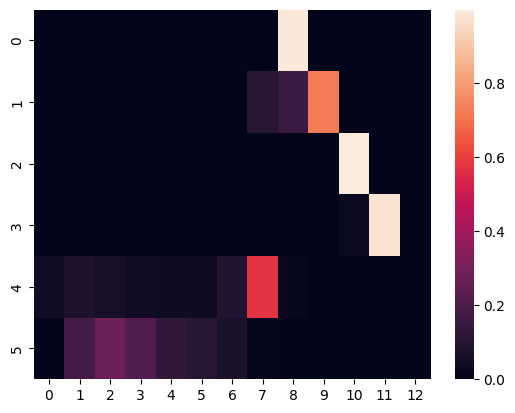

In [ ]:
import seaborn as sns

sns.heatmap(np.array(weights))

# Transformer

## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_embed, dropout, device):
        super().__init__()

        self.pos_encoded = self.encode(position, d_embed).to(device)

        self.dropout = nn.Dropout(p=dropout)

    def encode(self, length, depth): # 가산될 인코딩 값 계산 함수
        positions = np.arange(length).reshape(-1, 1)

        depth_even = np.arange(depth)[np.newaxis, ::2]*2/depth
        depth_odd = np.arange(depth)[np.newaxis, 1::2]*2/depth

        angle_rate_even = 1 / (10000**depth_even)
        angle_rate_odd = 1 / (10000**depth_odd)

        angle_rad_even = positions * angle_rate_even
        angle_rad_odd = positions * angle_rate_odd

        pos_encoding = np.zeros((length, depth))
        pos_encoding[:, ::2] = np.sin(angle_rad_even)
        pos_encoding[:, 1::2] = np.cos(angle_rad_odd)

        return torch.FloatTensor(pos_encoding).unsqueeze(0)

    def forward(self, inputs):
        seq_len = inputs.shape[1]
        out = self.dropout(inputs + self.pos_encoded[:, :seq_len, :])
        return out

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, seq_len, d_model, d_embed, vocab_size,
                 dropout, pad, device):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_embed, padding_idx=pad)
        self.positional_encoding = PositionalEncoding(seq_len, d_embed,
                                                      dropout, device)
        self.scaler = d_model**0.5

    def forward(self, inputs):
        out = self.embed(inputs) * self.scaler
        out = self.positional_encoding(out)
        return out

## Multi-Head Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.d_k = d_k
        self.d_k_sqrt = self.d_k**(1/2)

    def forward(self, query, key, value, padding_mask, causal_mask):
        attention_score = torch.matmul(query, torch.transpose(key, -2, -1))/self.d_k_sqrt

        if padding_mask is not None and causal_mask is not None:
            mask = torch.maximum(causal_mask, padding_mask)
            attention_score = attention_score.masked_fill(mask==1, -1e9)
        elif padding_mask is not None:
            attention_score = attention_score.masked_fill(padding_mask==1, -1e9)
        elif causal_mask is not None:
            attention_score = attention_score.masked_fill(causal_mask==1, -1e9)

        attention_weight = torch.softmax(attention_score, dim=-1)
        attention_value = torch.matmul(attention_weight, value)

        return attention_score, attention_weight, attention_value

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_embed, n_heads, device):
        super().__init__()

        self.device = device
        self.d_model = d_model
        self.d_embed = d_embed
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.w_q = nn.Linear(d_embed, d_model, bias=False)
        self.w_k = nn.Linear(d_embed, d_model, bias=False)
        self.w_v = nn.Linear(d_embed, d_model, bias=False)
        self.w_0 = nn.Linear(d_model, d_embed, bias=False)

        self.attention = ScaledDotProductAttention(self.d_k)

        nn.init.kaiming_uniform_(self.w_q.weight)
        nn.init.kaiming_uniform_(self.w_k.weight)
        nn.init.kaiming_uniform_(self.w_v.weight)
        nn.init.kaiming_uniform_(self.w_0.weight)

    def forward(self, query, key, value=None, padding_mask=None, use_causal_mask=False):
        if value is None:
            value = key

        wq = self.w_q(query)
        wk = self.w_k(key)
        wv = self.w_v(value)

        wq = wq.view(wq.shape[0], -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        wk = wk.view(wk.shape[0], -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        wv = wv.view(wv.shape[0], -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)

        if use_causal_mask:
            causal_mask = self._get_causal_mask(wq)
        else:
            causal_mask = None

        attention_score, attention_weight, attention_value = self.attention(
            wq, wk, wv, padding_mask=padding_mask, causal_mask=causal_mask)

        attention_value = attention_value.permute(0, 2, 1, 3)
        out = self.w_0(attention_value.contiguous().view(
            attention_value.shape[0], -1, self.d_model))

        return out, attention_score, attention_weight, attention_value

    def _get_causal_mask(self, x):
        mask = torch.ones((x.shape[-2], x.shape[-2]),
                          device=torch.device(self.device)).triu(diagonal=1)
        return mask

In [ ]:
class PositionWiseFedForwardNeuralNetwork(nn.Module):
    def __init__(self, d_embed, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_embed, d_ff)
        self.fc2 = nn.Linear(d_ff, d_embed)
        self.relu = nn.ReLU()

        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        return out

## Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, d_embed, d_ff, n_heads, dropout, device):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, d_embed, n_heads, device)

        self.dropout = nn.Dropout(p=dropout)

        self.layernorm1 = nn.LayerNorm(d_embed)
        self.layernorm2 = nn.LayerNorm(d_embed)

        self.fc = PositionWiseFedForwardNeuralNetwork(d_embed, d_ff)

    def forward(self, x, padding_mask=None):
        out, a, w, v = self.attention(x, x, padding_mask=padding_mask) # self attention
        out = self.dropout(out) # dropout
        out1 = self.layernorm1(x+out) # Residual Connection and Layer Normalization
        out2 = self.fc(out1) # PWFFN
        out2 = self.dropout(out2) # dropout
        out = self.layernorm2(out1+out2) # Residual Connection and Layer Normalization

        return out

## Decoder

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, d_model, d_embed, d_ff, n_heads, dropout, device):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, d_embed, n_heads, device)
        self.cross_attention = MultiHeadAttention(d_model, d_embed, n_heads, device)

        self.dropout = nn.Dropout(p=dropout)

        self.layernorm1 = nn.LayerNorm(d_embed)
        self.layernorm2 = nn.LayerNorm(d_embed)
        self.layernorm3 = nn.LayerNorm(d_embed)

        self.fc = PositionWiseFedForwardNeuralNetwork(d_embed, d_ff)

    def forward(self, x, enc_out, self_padding_mask=None, cross_padding_mask=None):
        out, a, w, v = self.self_attention(x, x, # self attention
                                           padding_mask=self_padding_mask, use_causal_mask=True)
        out = self.dropout(out) # dropout
        out1 = self.layernorm1(x+out) # Residual Connection and Layer Normalization
        out2, a, w, v = self.cross_attention(out1, enc_out, # cross attention
                                             padding_mask=cross_padding_mask)
        out2 = self.dropout(out2) # dropout
        out1 = self.layernorm2(out1+out2) # Residual Connection and Layer Normalization
        out2 = self.fc(out1) # PWFFN
        out2 = self.dropout(out2) # dropout
        out = self.layernorm3(out1+out2) # Residual Connection and Layer Normalization

        return out

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model, d_embed, d_ff,
                 n_heads, dropout, n_layers, pad, device):
        super().__init__()

        self.positional_embedding = PositionalEmbedding(seq_len, d_model, d_embed,
                                                        vocab_size, dropout, pad, device)
        self.encoders = nn.ModuleList()

        self.n_layers = n_layers

        for i in range(n_layers):
            self.encoders.append(TransformerEncoder(d_model, d_embed, d_ff,
                                                    n_heads, dropout, device))

    def forward(self, x, mask=None):
        out = self.positional_embedding(x)

        for i in range(self.n_layers):
            out = self.encoders[i](out, padding_mask=mask)
        return out

In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model, d_embed, d_ff,
                 n_heads, dropout, n_layers, pad, device):
        super().__init__()

        self.positional_embedding = PositionalEmbedding(seq_len, d_model, d_embed,
                                                        vocab_size, dropout, pad, device)
        self.decoders = nn.ModuleList()

        self.n_layers = n_layers

        for i in range(n_layers):
            self.decoders.append(TransformerDecoder(d_model, d_embed, d_ff,
                                                    n_heads, dropout, device))

    def forward(self, x, enc_out, self_mask=None, cross_mask=None):
        out = self.positional_embedding(x)

        for i in range(self.n_layers):
            out = self.decoders[i](out, enc_out,
                                   self_padding_mask=self_mask, cross_padding_mask=cross_mask)
        return out

## Transformer Model

In [ ]:
class Transformer(nn.Module):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_len, dec_seq_len,
                 d_model=128, d_embed=128, d_ff=256, n_heads=2, dropout=0.1,
                 n_layers=2, pad=0, device='cpu'):
        super().__init__()

        self.device = device

        self.encoder_block = TransformerEncoderBlock(enc_vocab_size, enc_seq_len,
                                                     d_model, d_embed, d_ff, n_heads,
                                                     dropout, n_layers, pad, device)
        self.decoder_block = TransformerDecoderBlock(dec_vocab_size, dec_seq_len,
                                                     d_model, d_embed, d_ff, n_heads,
                                                     dropout, n_layers, pad, device)

        self.fc = nn.Linear(d_embed, dec_vocab_size)

        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, enc_input, dec_input, pad=0):
        enc_self_padding_mask = self._get_qk_padding_mask(enc_input, enc_input, pad).to(self.device)
        dec_self_padding_mask = self._get_qk_padding_mask(dec_input, dec_input, pad).to(self.device)
        dec_cross_padding_mask = self._get_qk_padding_mask(dec_input, enc_input, pad).to(self.device)

        enc_out = self.encoder_block(enc_input, enc_self_padding_mask)
        dec_out = self.decoder_block(dec_input, enc_out, dec_self_padding_mask, dec_cross_padding_mask)

        out = self.fc(dec_out)
        return out

    def _get_padding_mask(self, x, pad):
        mask = (x==pad)
        return mask.to(torch.int32)

    def _get_qk_padding_mask(self, query, key, pad):
        query_mask = self._get_padding_mask(query, pad)
        key_mask = self._get_padding_mask(key, pad)

        query_mask = query_mask.unsqueeze(1).unsqueeze(3)
        key_mask = key_mask.unsqueeze(1).unsqueeze(2)

        query_mask = query_mask.repeat(1, 1, 1, key.shape[1])
        key_mask = key_mask.repeat(1, 1, query.shape[1], 1)

        mask = query_mask | key_mask

        return mask

In [ ]:
enc_vocab_size = len(vocab_spa_torch.get_stoi())
enc_seq_len = encoder_inputs_train_torch.shape[1]

dec_vocab_size = len(vocab_eng_torch.get_stoi())
dec_seq_len = decoder_inputs_train_torch.shape[1]

In [ ]:
# enc_vocab_size, dec_vocab_size, enc_seq_len, dec_seq_len, d_model=128, d_embed=128, d_ff=64, n_heads=2, dropout=0.1, n_layers=5
model = Transformer(enc_vocab_size, dec_vocab_size, enc_seq_len, dec_seq_len)

In [ ]:
pe = PositionalEncoding(16, 64, 0.0, device)
data = pe.pos_encoded.squeeze(0).detach().cpu().numpy()
pe.pos_encoded.shape

torch.Size([1, 16, 64])

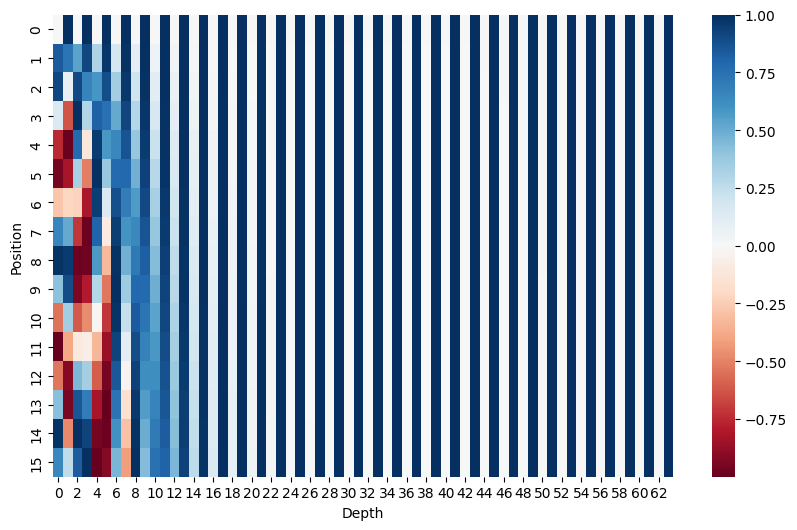

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.figure(figsize=(10, 6))
sns.heatmap(data, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.show()

In [ ]:
torch.manual_seed(777)

enc_vocab_size = len(vocab_spa_torch.get_stoi())
enc_seq_len = encoder_inputs_train_torch.shape[1]

dec_vocab_size = len(vocab_eng_torch.get_stoi())
dec_seq_len = decoder_inputs_train_torch.shape[1]

model = Transformer(enc_vocab_size, dec_vocab_size,  enc_seq_len,  dec_seq_len,
                    d_model=128, d_embed=128, d_ff=256, n_heads=4, dropout=0.1, n_layers=2,
                    pad=target_pad_token_idx, device=device).to(device)
loss = nn.CrossEntropyLoss(ignore_index=target_pad_token_idx).to(device)
optimizer = optim.Adam(model.parameters(), lr=1, eps=1e-9, betas=(0.9, 0.98))

In [ ]:
summary(model)

Layer (type:depth-idx)                                            Param #
Transformer                                                       --
├─TransformerEncoderBlock: 1-1                                    --
│    └─PositionalEmbedding: 2-1                                   --
│    │    └─Embedding: 3-1                                        1,655,424
│    │    └─PositionalEncoding: 3-2                               --
│    └─ModuleList: 2-2                                            --
│    │    └─TransformerEncoder: 3-3                               131,968
│    │    └─TransformerEncoder: 3-4                               131,968
├─TransformerDecoderBlock: 1-2                                    --
│    └─PositionalEmbedding: 2-3                                   --
│    │    └─Embedding: 3-5                                        852,352
│    │    └─PositionalEncoding: 3-6                               --
│    └─ModuleList: 2-4                                            --
│    │ 

## Model 학습

In [ ]:
class WarmupLRScheduler(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model,  warmup_steps, last_epoch=-1):
        def lambda_lr(step):
            arg1 = step**-0.5 if step > 0 else 0
            arg2 = step * (warmup_steps ** -1.5)
            return (d_model**-0.5) * min(arg1, arg2)
        super().__init__(optimizer, lambda_lr, last_epoch=last_epoch)

In [ ]:
d_model=128
warmup_steps=4000
scheduler = WarmupLRScheduler(optimizer, d_model, warmup_steps)

In [ ]:
# values = []
# for step in range(40000):
#     arg1 = step**-0.5 if step > 0 else 0
#     arg2 = step * (warmup_steps ** -1.5)
#     values.append((d_model**-0.5) * min(arg1, arg2))

In [ ]:
# plt.figure(figsize=(12, 5))
# plt.plot(range(40000), values)
# plt.xlabel('Train Step')
# plt.ylabel('Learning Rate')

In [ ]:
from tqdm import tqdm

n_epochs = 50 # epochs 수

results = {'Loss':[], 'Val_Loss':[]}

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    train_loss = 0
    valid_loss = 0

    n_train_batches = len(train_loader)
    n_valid_batches = len(valid_loader)

    model.train() # 학습 모드
    for enc_x, dec_x, dec_y in train_loader:
        enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
        h = model(enc_x, dec_x) # 예측 값 생성
        cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

        optimizer.zero_grad() # 기울기 초기화
        cost.backward()       # 역전파 수행
        optimizer.step()      # 기울기 업데이트
        scheduler.step()      # 학습률 업데이트

        train_loss += cost/n_train_batches
    pbar.set_postfix(epoch=f'{epoch:2d}', loss=f'{train_loss.item():9.5f}')
    results['Loss'].append(train_loss.item())

    model.eval()
    with torch.no_grad():
        for enc_x, dec_x, dec_y in valid_loader:
            enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
            h = model(enc_x, dec_x) # 예측 값 생성
            cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

            valid_loss += cost/n_valid_batches
        pbar.set_postfix(epoch=f'{epoch:2d}',
                         loss=f'{train_loss.item():9.5f}', val_loss=f'{valid_loss.item():9.5f}')
        results['Val_Loss'].append(valid_loss.item())

100%|██████████| 50/50 [05:22<00:00,  6.45s/it, epoch=49, loss=0.46040, val_loss=1.24743]


## 추론

In [ ]:
def predict(x_input, target_len=10):
    outputs = []

    start_token = vocab_eng_torch.get_stoi()['<sos>']
    pad = vocab_eng_torch.get_stoi()['<PAD>']
    eng_itos = vocab_eng_torch.get_itos()

    model.eval()
    with torch.no_grad():
        input_sequence = [start_token] + ([pad]*(target_len-1))
        decoder_input = torch.LongTensor(input_sequence).reshape(1, -1).to(device)

        for t in range(target_len):
            out = model(x_input, decoder_input)
            c_token = out[:, t, :].argmax(dim=1)
            decoder_input[:, t+1] = c_token
            word = eng_itos[c_token.item()]
            if word == '<eos>':
                break
    outputs = ' '.join([eng_itos[idx] for idx in decoder_input.view(-1)[1:t+1]])
    return outputs

In [ ]:
def preprocessing(text, max_len=13):
    seq = text_preprocess(text).split()
    seq = ['<PAD>']*(max_len-len(seq))+seq
    seq = sent2seq_spa([seq])
    seq = torch.LongTensor(seq)
    return seq

data = preprocessing(df.iloc[47855, 1]).to(device)
pred = predict(data)
print('spanish:', df.iloc[47855, 1])
print('english:', pred)

spanish: Tienen que ser más respetuosos.
english: they must be more polite .


In [ ]:
data = preprocessing(df.iloc[30402, 1]).to(device)
pred = predict(data)
print('spanish:', df.iloc[30402, 1])
print('english:', pred)

spanish: ¿Es esto suficiente dinero?
english: is this enough money ?


# torch.nn.Transformer

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_len, dec_seq_len,
                 d_model=128, d_embed=128, d_ff=256, n_heads=2, dropout=0.1,
                 n_layers=2, pad=0, device='cpu'):
        super().__init__()
        self.device = device
        self.pad = pad

        self.enc_embed = PositionalEmbedding(enc_seq_len, d_model, d_embed, enc_vocab_size, dropout, pad, device)
        self.dec_embed = PositionalEmbedding(dec_seq_len, d_model, d_embed, dec_vocab_size, dropout, pad, device)
        self.transformer = nn.Transformer(d_model, n_heads, n_layers, n_layers,
                                          d_ff, dropout, batch_first=True, device=torch.device(device))
        self.fc = nn.Linear(d_model, dec_vocab_size)

    def forward(self, encoder_input, decoder_input):
        enc_out = self.enc_embed(encoder_input)
        dec_out = self.dec_embed(decoder_input)

        enc_padding_mask = (encoder_input == self.pad).to(self.device)
        dec_padding_mask = (decoder_input == self.pad).to(self.device)
        dec_mask = self.transformer.generate_square_subsequent_mask(decoder_input.size(1)).bool().to(self.device)
        out = self.transformer(enc_out, dec_out,
                               src_key_padding_mask=enc_padding_mask,
                               tgt_key_padding_mask=dec_padding_mask,
                               memory_key_padding_mask=enc_padding_mask, tgt_mask=dec_mask)
        out = self.fc(out)
        return out

In [ ]:
torch.manual_seed(777)

enc_vocab_size = len(vocab_spa_torch.get_stoi())
enc_seq_len = encoder_inputs_train_torch.shape[1]

dec_vocab_size = len(vocab_eng_torch.get_stoi())
dec_seq_len = decoder_inputs_train_torch.shape[1]

model = TransformerModel(enc_vocab_size, dec_vocab_size,  enc_seq_len,  dec_seq_len,
                    d_model=128, d_embed=128, d_ff=256, n_heads=4, dropout=0.1, n_layers=2,
                    pad=target_pad_token_idx, device=device).to(device)
loss = nn.CrossEntropyLoss(ignore_index=target_pad_token_idx).to(device)
optimizer = optim.Adam(model.parameters(), lr=1, eps=1e-9, betas=(0.9, 0.98))

In [ ]:
d_model=128
warmup_steps=4000
scheduler = WarmupLRScheduler(optimizer, d_model, warmup_steps)

In [ ]:
from tqdm import tqdm

n_epochs = 50 # epochs 수

results = {'Loss':[], 'Val_Loss':[]}

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    train_loss = 0
    valid_loss = 0

    n_train_batches = len(train_loader)
    n_valid_batches = len(valid_loader)

    model.train() # 학습 모드
    for enc_x, dec_x, dec_y in train_loader:
        enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
        h = model(enc_x, dec_x) # 예측 값 생성
        cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

        optimizer.zero_grad() # 기울기 초기화
        cost.backward()       # 역전파 수행
        optimizer.step()      # 기울기 업데이트
        scheduler.step()      # 학습률 업데이트

        train_loss += cost/n_train_batches
    pbar.set_postfix(epoch=f'{epoch:2d}', loss=f'{train_loss.item():9.5f}')
    results['Loss'].append(train_loss.item())

    model.eval()
    with torch.no_grad():
        for enc_x, dec_x, dec_y in valid_loader:
            enc_x, dec_x, dec_y = enc_x.to(device), dec_x.to(device), dec_y.to(device)
            h = model(enc_x, dec_x) # 예측 값 생성
            cost = loss(h.view(-1, h.shape[2]).to(device), dec_y.view(-1)) # cost 계산

            valid_loss += cost/n_valid_batches
        pbar.set_postfix(epoch=f'{epoch:2d}',
                         loss=f'{train_loss.item():9.5f}', val_loss=f'{valid_loss.item():9.5f}')
        results['Val_Loss'].append(valid_loss.item())

  0%|          | 0/50 [00:06<?, ?it/s, epoch=0, loss=7.08868]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|██████████| 50/50 [05:40<00:00,  6.81s/it, epoch=49, loss=0.41200, val_loss=1.21330]
